# Imports

In [1]:
!pip install matplotlib==3.10.0 -q
!pip install pandas==2.2.2 -q
!pip install pymorphy3==2.0.3 -q
!pip install -U pymorphy3-dicts-ru -q
!pip install scikit-learn==1.6.1 -q
!pip install spacy==3.8.5 -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 54.7 MB/s eta 0:00:00
Reason for being yanked: Incorrect python3.13 support specified
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 57.2 MB/s eta 0:00:00


In [ ]:
# !pip freeze

In [2]:
import re

from itertools import chain
from pathlib import Path
from typing import Dict, Any

import matplotlib.pyplot as plt
import pandas as pd
import spacy

from pymorphy3 import MorphAnalyzer
from pymorphy3.tokenizers import simple_word_tokenize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from spacy.lang.ru import Russian

In [ ]:
# !unzip "/content/drive/MyDrive/Biaspectual_Verbs_Diploma/unbalanced_2verbs_dataset/train.json.zip" -d "/content/drive/MyDrive/Biaspectual_Verbs_Diploma/unbalanced_2verbs_dataset"
# !unzip "/content/drive/MyDrive/Biaspectual_Verbs_Diploma/unbalanced_2verbs_dataset/test.json.zip" -d "/content/drive/MyDrive/Biaspectual_Verbs_Diploma/unbalanced_2verbs_dataset"

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Text Preprocessing

In [129]:
class TextPreprocessor():
  def __init__(self,
               train_path,
               test_path):
    self.train = pd.read_json(
        Path(train_path),
        orient='records')
    self.test = pd.read_json(
        Path(test_path),
        orient='records')
    self.m = MorphAnalyzer()
    self.bi_verbs = set()
    self.vocab = set()
    self.unique_toks_analysed = {}

  def split_Xy(self, target_col):
    у_train = self.train[target_col]
    X_train = self.train.drop(columns=target_col)

    у_test = self.test[target_col]
    X_test = self.test.drop(columns=target_col)

    return X_train, X_test, у_train, у_test

  def encode_target(self, encode_func, y_train, y_test):
    y_train = y_train.apply(encode_func)
    y_test = y_test.apply(encode_func)
    return y_train, y_test

  def tokenize(self, tokenize_func, context_col, X_train, X_test):
    X_train[context_col + '_1'] = X_train[context_col].apply(tokenize_func)
    X_test[context_col + '_1'] = X_test[context_col].apply(tokenize_func)
    return X_train, X_test

  def build_bi_verbs_set(self, lemma_col, X_train, X_test):
    self.bi_verbs = self.bi_verbs | \
      set(pd.unique(X_train[lemma_col])) | \
      set(pd.unique(X_test[lemma_col]))
    return self.bi_verbs

  def build_vocab(self, tokenized_texts_col, X_train, X_test):
    tokenized_train = list(X_train[tokenized_texts_col])
    tokenized_test = list(X_test[tokenized_texts_col])
    flat_tokens = list(chain(*tokenized_train))
    flat_tokens.extend(list(chain(*tokenized_test)))
    self.vocab = set(flat_tokens)
    return self.vocab, len(flat_tokens)

  def unify_token_representation(self):
    tense_pat = re.compile(r'(pres|futr)')
    aspect_pat = re.compile(r'(perf|impf)')

    for tok in self.vocab:
      t = self.m.parse(tok)[0]
      if t.normal_form not in self.bi_verbs:
        self.unique_toks_analysed[tok] = {
          'lem': t.normal_form,
          'wf': t.word,
          'tag': str(t.tag)
        }
      else:
        tag = str(t.tag)
        tag = tense_pat.sub('pr-f', tag)
        tag = aspect_pat.sub('im-p', tag)

        self.unique_toks_analysed[tok] = {
          'lem': t.normal_form,
          'wf': t.word,
          'tag': tag
        }
    return self.unique_toks_analysed

  def preprocess_tokens(self, tokenized_texts_col, X_train, X_test):
    preproc_func = lambda x: [self.unique_toks_analysed[tok] for tok in x]
    X_train[tokenized_texts_col] = X_train[tokenized_texts_col].apply(
        preproc_func)
    X_test[tokenized_texts_col] = X_test[tokenized_texts_col].apply(
        preproc_func)
    return X_train, X_test

In [130]:
train_p = "/content/drive/MyDrive/Biaspectual_Verbs_Diploma/unbalanced_2verbs_dataset/train.json"
test_p = "/content/drive/MyDrive/Biaspectual_Verbs_Diploma/unbalanced_2verbs_dataset/test.json"

# perf = 1, impf = 0
encode_y = lambda x: 1 if x is True else 0
tokenize_f = lambda x: simple_word_tokenize(x.lower())

text_proc = TextPreprocessor(train_p, test_p)
X_train, X_test, y_train, y_test = text_proc.split_Xy('вид_совершенный')

In [131]:
y_train, y_test = text_proc.encode_target(encode_y, y_train, y_test)
X_train, X_test = text_proc.tokenize(tokenize_f, 'контекст', X_train, X_test)

bi_verbs = text_proc.build_bi_verbs_set('лемма', X_train, X_test)
vocab, wordform_occurs = text_proc.build_vocab('контекст_1', X_train, X_test)

text_proc.unify_token_representation()
X_train, X_test = text_proc.preprocess_tokens('контекст_1', X_train, X_test)


print(len(bi_verbs), bi_verbs)
print(len(vocab), vocab)
print(wordform_occurs)

289 {'американизироваться', 'колонизировать', 'дезинформировать', 'ажитировать', 'инициировать', 'дисквалифицировать', 'капитулировать', 'инвентаризировать', 'акцептовать', 'доследовать', 'феминизироваться', 'акцентировать', 'воздействовать', 'женить', 'синхронизировать', 'индивидуализировать', 'демифологизировать', 'русифицировать', 'фианкеттировать', 'катапультировать', 'стандартизировать', 'гарантировать', 'сочетать', 'декорировать', 'редуцировать', 'деактивировать', 'жениться', 'дезорганизовать', 'разблокировать', 'фраппировать', 'реструктуризировать', 'стабилизироваться', 'дезавуировать', 'ранить', 'американизировать', 'фрагментировать', 'десакрализовать', 'фиксировать', 'финишировать', 'диагностировать', 'актуализировать', 'инсталлировать', 'утрировать', 'акклиматизировать', 'активизировать', 'советизировать', 'стартовать', 'сообразоваться', 'колонизовать', 'инвертировать', 'протестовать', 'утилизировать', 'авансировать', 'экипировать', 'дискредитировать', 'абстрагироваться', 'ид

In [132]:
y_train.value_counts()

,count
вид_совершенный,
0,22807
1,8938


In [133]:
y_test.value_counts()

,count
вид_совершенный,
0,9864
1,3741


In [134]:
X_test['контекст_1'][0]

[{'lem': 'в', 'wf': 'в', 'tag': 'PREP'},
 {'lem': '1982-м',
  'wf': '1982-м',
  'tag': 'NOUN,inan,masc,Fixd,Abbr plur,gent'},
 {'lem': 'год', 'wf': 'году', 'tag': 'NOUN,inan,masc sing,loc2'},
 {'lem': 'в', 'wf': 'в', 'tag': 'PREP'},
 {'lem': 'сша',
  'wf': 'сша',
  'tag': 'NOUN,inan,GNdr,Pltm,Abbr,Fixd,Geox plur,gent'},
 {'lem': 'эмигрировать',
  'wf': 'эмигрировал',
  'tag': 'VERB,im-p,intr masc,sing,past,indc'},
 {'lem': 'и', 'wf': 'и', 'tag': 'CONJ'},
 {'lem': 'бобышева', 'wf': 'бобышев', 'tag': 'NOUN,anim,femn,Name plur,gent'},
 {'lem': '.', 'wf': '.', 'tag': 'PNCT'}]

# Constants

In [135]:
utility_tokens = {
    'somewhen': {'когда-нибудь', 'когда-либо'}, # СВ в презенсе, НСВ в прошедшем
    'каждый': frozenset(('день', 'вечер', 'час', 'месяц', 'год', 'раз', 'квартал', 'семестр', 'триместр', 'век')),
    'каждая': frozenset(('неделя', 'минута', 'секунда', 'осень', 'зима', 'весна', 'ночь', 'четверть', 'декада')),
    'каждую': frozenset(('неделю', 'минуту', 'секунду', 'осень', 'зиму', 'весну', 'ночь', 'четверть', 'декаду')),
    'каждое': frozenset(('утро', 'лето', 'воскресенье', 'полугодие', 'десятилетие', 'столетие', 'тысячелетие')),
    'каждые': frozenset(('сутки', )),
    ('раз', 'в'): frozenset(('день', 'час', 'месяц', 'год', 'неделю', 'минуту', 'секунду',
      'осень', 'зиму', 'весну')),
    'по': frozenset(('понедельникам', 'вторникам', 'средам', 'четвергам', 'пятницам',
      'субботам', 'воскресеньям', 'утрам', 'вечерам', 'ночам', 'январям',
      'февралям', 'мартам', 'апрелям', 'маям', 'июням', 'июлям', 'августам',
      'сентябрям', 'октябрям', 'ноябрям', 'декабрям')),
    'c': frozenset('каждым'), # днём вечером и т.д.
    'time_units_lemmas': frozenset(('полминуты', 'минута', 'день', 'вечер', 'час',
      'месяц', 'год', 'раз', 'квартал', 'семестр', 'триместр', 'век', 'неделя',
      'минута', 'секунда', 'осень', 'зима', 'весна', 'ночь', 'четверть',
      'декада', 'утро', 'лето', 'воскресенье', 'полугодие', 'десятилетие',
      'столетие', 'тысячелетие', 'сутки', 'полдень', 'полмесяца', 'полгода',
      'полсекунды', 'полчаса'))
}

impf_contexts = {
  'anal_futr': {'будет', 'будут', 'будем', 'буду', 'будешь', 'будете'},
  'phase': {'начать', 'начинать', 'стать', 'продолжить', 'nродолжать',
    'кончить', 'кончать', 'бросить', 'бросать', 'закончить', 'заканчивать',
    'окончить', 'оканчивать', 'покончить', 'стартовать', 'пуститься', 'пускаться',
    'бросить', 'бросать', 'перестать', 'переставать', 'прекратить',
    'прекращать'},
  'neg_modal': {'надо', 'нужно', 'стоить', 'следовать', 'подобать', 'надобно',
    'рекомендуется',('к', 'лицу'), 'должный', 'обязать', 'принятый', 'намеренный', 'рад'},
  'negative_eval': {'вредно', 'больно', 'грустно', 'бесполезно', 'скучно', 'невыносимо',
    'плохо', 'тоскливо', 'противно', 'неинтересно', 'неприятно', 'опасно',
    'упорно', 'настойчиво'},
  'performative_neg': {'советовать', 'посоветовать', 'просить', 'попросить',
    'предлагать', 'предложить', 'рекомендовать', 'порекомендовать', 'обещать',
    'пообещать', 'договориться', 'договариваться', 'решить', 'решать',
    'постановить', 'постановлять', frozenset(('дать', 'слово')), frozenset(('давать', 'слово')),
    frozenset(('взять', ('на', 'себя'), 'обязательство')),
    'обязаться', frozenset(('брать', ('на', 'себя'), 'обязательство')), 'обязываться', 'клясться',
    'поклясться', frozenset(('принять', 'решение')), frozenset(('принимать', 'решение')), 'убеждать',
    'убедить', 'призывать', 'призвать', 'разрешать', 'разрешить', 'уговорить',
    'уговаривать', 'приказать', 'приказывать', 'упросить', 'упрашивать',
    frozenset(('выступить', ('с', 'предложением'))), frozenset(('выступать', ('с', 'предложением'))),
    frozenset(('вносить', 'предложение')), frozenset(('внести', 'предложение')), 'велеть',
    'потребовать', 'требовать', 'распорядиться', 'распоряжаться',
    frozenset(('издать', 'распоряжение')), frozenset(('издавать', 'распоряжение'))},
  'deverb': {'манера', 'привычка'},
  'deverb_neg': {'привычка', 'стремление', 'умение', 'желание', 'способность', 'готовность',
    'попытка', 'мечта', 'грёзы', 'старание', 'навык', 'страсть', 'совет', 'просьба',
    'предложение', 'рекомендация', 'обещание', 'договор', 'решение',
    'постановление', 'обязательство', 'клятва', 'убеждение', 'призыв',
    'разрешение', 'уговор', 'приказ', 'упрашивание', 'веление', 'требование',
    'распоряжение'},
  'why_inf': {'зачем'},
  'stop_phrases': {frozenset(('сколько', 'можно')), 'хватит', 'довольно',
                   'надоело', 'запрещено', 'противопоказано'},
  'eval_v': {'разонравиться', 'наскучить', 'наскучивать', 'надоесть', 'научить',
    'надоедать', 'устать', 'уставать', 'отвыкнуть', 'отвыкать', 'разучиться',
    'разучиваться', 'отучить', 'отучать', 'отучиться', 'отучаться', 'нравиться',
    'понравиться', 'привыкнуть', 'привыкать', 'учиться', 'научиться', 'учить',
    'запрещается', 'уметь'},
  'indef_multiplicity': {'часто', 'нечасто', 'редко', 'нередко',
    'изредка', 'всегда', 'невсегда', 'иногда', 'нерегулярно', 'несистематически',
    'непродолжительно', 'недолго', 'эпизодически',
    'обычно', 'неизменно', 'постоянно', 'временами', 'регулярно', 'вечно',
    'периодически', 'систематически', 'бесперебойно', 'длительно', 'порой',
    'продолжительно', ' долго', 'перманентно', 'ежегодно', 'ежесезонно', 'ежемесячно',
    'еженедельно', 'ежесекундно', 'ежедневно', 'еженощно', 'ежеминутно',
    'ежечасно', 'посезонно', 'помесячно', 'понедельно', 'поминутно',
    'посекундно', 'утрами', 'вечерами', 'полуднями', 'ночами', 'непрерывно', 'неуклонно', ('всё', 'время'),
    ('с', 'перерывами'), ('как', 'правило'), ('время', 'от', 'времени'),
    ('от', 'случая', 'к', 'случаю'), ('каждый', utility_tokens['каждый']),
    ('каждая', utility_tokens['каждая']), ('каждая', utility_tokens['каждое']),
    ('раз', 'в', utility_tokens[('раз', 'в')]), ('по', utility_tokens['по']),
    ('то', 'и', 'дело')},
  'all': {('давно', 'не'), ('всё', 'ещё'), ('никогда', 'не')},
  'multiplicity_phrases': {('с', 'каждым', 'годом'),
    ('день', 'ото', 'дня'),
    ('из', 'месяца', 'в', 'месяц')}, # и аналогичные с сущ в знач. временнго промежутка
  'growing_intencity': {'всё', ('больше', 'меньше', 'чаще', 'реже', 'лучше', 'хуже', 'быстрее', 'медленнее')},
  'already_n_neg': {'уже', 'неделю/любое сущ со значением временного отрезка', 'не', 'делал/делает'},
  'earlier': {'раньше'}
}

perf_contexts = {
  'single': {'успеть', 'преуспеть', 'суметь', 'удаться', 'смочь',
    'постараться', 'попытаться', 'умудриться', 'забыть', 'позабыть', 'запамятовать'},
  'modal_neg': {'надо', 'нужно'}, # реализовать
  'request': {'дай', 'давай', 'давайте', 'дай-ка', 'давай-ка', 'давайте-ка'},
  'past_suddenn_action_adv': {'вдруг', 'внезапно', 'нежданно', 'негаданно',
    'нежданно-негаданно', 'неожидаемо', 'непредвиденно',
    'врасплох', 'резко', 'спонтанно', 'тотчас', 'сразу', 'почти'},
  'modal': {'стоило'},
  'if_clause': {'если', 'ежели', 'кабы', 'коли', 'коль'},
  'time_frame': {'день', 'вечер', 'час', 'месяц', 'год', 'раз', 'квартал', 'семестр', 'триместр', 'век',
    'дня', 'вечера', 'часа', 'месяца', 'года', 'раза', 'квартала', 'семестра', 'триместра', 'века',
    'дней', 'вечеров', 'часов', 'месяцев', 'лет', 'раз', 'кварталов', 'семестров', 'триместров', 'веков',
    'неделю', 'минуту', 'секунду', 'осень', 'зиму', 'весну', 'ночь', 'четверть', 'декаду',
    'недели', 'минуты', 'секунды', 'осени', 'зимы', 'весны', 'ночи', 'четверти', 'декады',
    'недель', 'минут', 'секунд', 'осеней', 'зим', 'вёсен', 'ночей', 'четвертей', 'декад',
    'утро', 'лето', 'воскресенье', 'полугодие', 'десятилетие', 'столетие', 'тысячелетие',
    'утра', 'лета', 'воскресенья', 'полугодия', 'десятилетия', 'столетия', 'тысячелетия',
    'утр', 'лет', 'воскресений', 'полугодий', 'десятилетий', 'столетий', 'тысячелетий',
    'сутки', 'суток', 'полсекунды', 'полминуты', 'полдень', 'полмесяца', 'полгода', 'полсекунды', 'полчаса'},
  'futr_modal_adv': {'непременно', 'точно', 'обязательно', 'возможно', 'вероятно',
   ('может' 'быть'), 'может', ('скорее', 'всего'), 'наверно',
    'наверное', 'неминуемо', 'неизбежно', ('с', 'высокой', 'вероятностью')},
  'deverb': {'шанс', 'мысль'}
  }

aspect_compet = {
  ('никак', 'не'),
  ('всё', 'не'),
  'дважды',
  'трижды',
  'четырежды',
  ('N', 'раза'),
  ('N', 'раз'),
  'успевать', 'преуспевать', 'удаваться', 'мочь', 'стараться', 'пытаться',
  'умудряться', 'забывать',
  ('делай', 'как', 'можно', 'позже'), # здесь в качестве компаратива наречия - любое БЕЗ ЗНАЧЕНИЯ повторяемости
  ('всё', 'ещё', 'не'), # всё ещё не ел, съел (тут внутри времени ситуации), поел, сейм - пить, попить, выпить
  ('давно', 'делал/сделал'), # попытка vs. успешная попытка
  ('до', 'сих', 'пор', 'не', 'делала/сделала')}

In [136]:
words = list(chain(*impf_contexts.values())) + list(chain(*perf_contexts.values()))

words2proc = [tok for tok in words if isinstance(tok, str)] + ['не']
m = MorphAnalyzer()
pos2proc = set()

for tok in words2proc:
# for tok in perf_contexts['futr_modal_adv']:
  if isinstance(tok, str):
    t = m.parse(tok)[0]
    pos2proc.add(str(t.tag.POS))
    if str(t.tag.POS) == 'COMP':
      print(t.word, t.tag)

print(pos2proc)

раньше COMP
{'ADJS', 'PREP', 'ADVB', 'PRTS', 'NOUN', 'PRCL', 'PRED', 'CONJ', 'INFN', 'VERB', 'PRTF', 'ADJF', 'COMP'}


In [137]:
def singleton(cls):
  instances = {}
  def getinstance(*args, **kwargs):
    if cls not in instances:
      instances[cls] = cls(*args, **kwargs)
    return instances[cls]
  return getinstance

@singleton
class LoadConstants():
  def __init__(self, perf_contexts, impf_contexts):
    self.IMPF, self.PERF = 'impf', 'perf'
    self.VERBS = bi_verbs
    self.POS2PROC = {'COMP', 'PRCL', 'PREP', 'PRTF', 'ADJS',
                     'PRTS', 'PRED', 'ADJF', 'ADVB', 'CONJ',
                     'NOUN', 'INFN', 'VERB'} # -CONJ

    # ДВГ в инфинитиве => НСВ
    self.WHY = impf_contexts['why_inf']
    self.STOP = impf_contexts['stop_phrases']
    self.FUTR = impf_contexts['anal_futr']
    self.PHASE_V = impf_contexts['phase']
    self.EVAL_V = impf_contexts['eval_v']
    # Отрицание перед глаголом из этой группы
    self.MODAL_W = impf_contexts['neg_modal']
    # обрабатывать вместе с другими обстоятельствами
    # по семантике сближаются с модальными словами с отрицанием
    self.NEG_EVAL = impf_contexts['negative_eval']
    self.WHY = impf_contexts['why_inf']
    self.STOP_PHRASES = impf_contexts['stop_phrases']
      # Отрицание после глагола из этой группы
    self.PERFORM_NEG = impf_contexts['performative_neg']
    self.DEVERB_NEG = impf_contexts['deverb_neg']
    self.DEVERB = impf_contexts['deverb']
    # ДВГ в инфинитиве => СВ, обрабатывать с другими инфинитивами
    self.SINGLE = perf_contexts['single']
    self.TIME_ADV = perf_contexts['time_frame']
    self.MODAL_V = perf_contexts['modal']
    self.MODAL_W_NEG = perf_contexts['modal_neg']

    # Наречия и обстоятельства
    self.INDEF_MULTI = impf_contexts['indef_multiplicity']
    self.NEG_EVAL = impf_contexts['negative_eval']

    # ДВГ в прошедшем => НСВ, ДВГ в презенсе => СВ
    self.SOMEWHEN = utility_tokens['somewhen']
    # ДВГ в презенсе => СВ
    self.CONF_ADV = perf_contexts['futr_modal_adv']
    # ДВГ в прошедшем => НСВ
    self.EARLIER = impf_contexts['earlier']
    # ДВГ в прошедшем => СВ
    self.PAST_SUDDEN_ACT = perf_contexts['past_suddenn_action_adv']
    self.REQUEST = perf_contexts['request']

In [138]:
print(*impf_contexts.values())

{'будете', 'будем', 'будут', 'будешь', 'будет', 'буду'} {'продолжить', 'окончить', 'прекратить', 'начать', 'покончить', 'прекращать', 'начинать', 'переставать', 'бросать', 'заканчивать', 'пуститься', 'кончать', 'кончить', 'бросить', 'закончить', 'оканчивать', 'перестать', 'стать', 'стартовать', 'nродолжать', 'пускаться'} {'нужно', 'намеренный', 'рад', 'стоить', 'обязать', 'надобно', 'подобать', 'рекомендуется', 'должный', ('к', 'лицу'), 'надо', 'следовать', 'принятый'} {'плохо', 'неприятно', 'больно', 'тоскливо', 'противно', 'опасно', 'настойчиво', 'бесполезно', 'грустно', 'скучно', 'упорно', 'невыносимо', 'вредно', 'неинтересно'} {'просить', 'призывать', 'договариваться', frozenset({'брать', ('на', 'себя'), 'обязательство'}), 'потребовать', frozenset({'издавать', 'распоряжение'}), 'приказывать', 'предложить', 'поклясться', 'порекомендовать', 'договориться', 'убедить', 'обязаться', 'обязываться', 'решить', 'приказать', frozenset({'выступить', ('с', 'предложением')}), 'постановлять', fr

# Model

In [139]:
class Disambiguate():
    CONS = LoadConstants(perf_contexts, impf_contexts)
    IMPF, PERF, COMPET, INDEF = 0, 1, -1, -2
    VERBS = CONS.VERBS
    POS2PROC = CONS.POS2PROC

    FUTR = CONS.FUTR | CONS.WHY | CONS.STOP
    PHASE_EVAL_V = CONS.PHASE_V | CONS.EVAL_V
    SINGLE = CONS.SINGLE

    MODAL_V = CONS.MODAL_V
    MODAL_W = CONS.MODAL_W
    POTENT_NEG = CONS.PERFORM_NEG | CONS.DEVERB_NEG
    MODAL_W_NEG = CONS.MODAL_W_NEG
    DEVERB = CONS.DEVERB

    MULTI_NEG = CONS.INDEF_MULTI | CONS.NEG_EVAL

    SOMEWHEN = CONS.SOMEWHEN
    CONF_ADV = CONS.CONF_ADV
    PAST_SUDDEN_ACT = CONS.PAST_SUDDEN_ACT
    EARLIER = CONS.EARLIER

    REQUEST = CONS.REQUEST
    TIME_ADV = CONS.TIME_ADV

    def __init__(self):
      self.for_infn = {}
      self.neg_mod_infn = {}
      self.potent_neg_infn = {}
      self.indef_multi = {}
      self.past_sudden_act = {}
      self.request = {}
      self.time_frame_span = []
      self.bi_v = []
      self.relation = []
      self.relation_list = []
      self.time_frame_advbs = {
          ('IN', 'N', 'TIME_PER'),
          ('IN', 'TIME_PER', 'N'),
          ('TIME_PER', 'IN', 'N'),
          ('IN', 'TIME_PER')
          }
      self.time_span_advbs = {
          ('N', 'TIME_PER'),
          ('TIME_PER', 'N'),
          ('TIME_PER',)
          }

    def proc_base(self):
      if self.bi_v:
        last_bi_verb = self.bi_v[-1]
        lem, tag = last_bi_verb['lem'], last_bi_verb['tag']
        if lem.endswith('ировать') or \
        not lem.endswith('овать'):
          if 'pr-f' in tag or 'INFN' in tag or 'impr' in tag:
            return Disambiguate.IMPF
          else:
            return Disambiguate.PERF
        elif lem.endswith('овать'):
          if 'past' in tag or 'INFN' in tag:
            return Disambiguate.PERF
          else:
            return Disambiguate.IMPF
      return Disambiguate.IMPF

    def proc_tok(self, token_dict, indx, len_text):
      tok_pos = token_dict['tag'][:4]
      token_dict['inx'] = indx
      if tok_pos in Disambiguate.POS2PROC:
        if tok_pos == 'PRCL':
          self.proc_PRCL(token_dict)

        if tok_pos in {'PRTF', 'ADJS', 'VERB',
                        'PRED', 'INFN', 'PRTS',
                        'ADJF', 'NOUN', 'ADVB'}:
          self.proc_MODAL_W(token_dict)
          self.proc_FUTR(token_dict)
          self.proc_PHASE_EVAL_V(token_dict)
          self.proc_SINGLE(token_dict)
          self.proc_POTENT(token_dict)
          self.proc_MULTI_NEG(token_dict)
          self.proc_PAST_SUDDEN_ACT(token_dict)
          self.proc_REQUEST(token_dict)
          self.proc_relation(token_dict)
        if tok_pos in {'ADVB', 'ADJS', 'ADJF',
                        'PRED', 'NOUN', 'PREP',
                        'NUMB', 'NUMR'}:
          self.proc_MULTI_NEG(token_dict)
          self.proc_TIME_FRAME_SPAN(token_dict)

      elif tok_pos in {'PNCT', 'CONJ'}:
        if token_dict['lem'] in '...!?' and token_dict['inx'] < len_text - 1:
          self.for_infn.clear()
          self.neg_mod_infn.clear()
          self.potent_neg_infn.clear()
          self.indef_multi.clear()
          self.past_sudden_act.clear()
          self.request.clear()
          self.time_frame_span.clear()
        elif token_dict['lem'] in ',':
          pass

    def coordination(self, bi_verb, candidate):
      cand_tag = []
      for gram in candidate['tag'].split(','):
        if ' ' in gram:
          cand_tag.extend(gram.split())

      bi_v_tag = []
      for gram in bi_verb['tag'].split(','):
        if ' ' in gram:
          bi_v_tag.extend(gram.split())
      coord_grammemes = {'VERB', 'INFN', 'sing', 'plur',
                          'indc', 'impr',
                          'femn', 'masc', 'neut',
                          '1per', '2per', '3per'}
      cand_coord_gram = set(cand_tag) & coord_grammemes
      bi_v_coord_gram = set(bi_v_tag) & coord_grammemes
      return cand_coord_gram == bi_v_coord_gram

    def control(self, bi_verb, candidate):
      return candidate['tag'][:4] in {'INFN', 'VERB'} and \
      'tran' in candidate['tag'] and bi_verb['tag'][:4] == 'INFN'

    def proc_relation(self, tok_dict):
      if tok_dict['tag'][:4] in {'VERB', 'INFN'}:
        if tok_dict['lem'] in Disambiguate.VERBS:
          self.bi_v.append(tok_dict)
        else:
          self.relation.append(tok_dict)

        while self.bi_v and self.relation:
          bi_verb = self.bi_v[-1]
          candidate = self.relation.pop(-1)

          if self.control(bi_verb, candidate) or self.coordination(bi_verb, candidate):
            if 'perf' in candidate['tag']:
              self.relation_list.append(Disambiguate.PERF)
            elif 'impf' in candidate['tag']:
              self.relation_list.append(Disambiguate.IMPF)

    def proc_FUTR(self, tok_dict):
      if tok_dict['wf'] in Disambiguate.FUTR:
        self.for_infn['FUTR'] = tok_dict
      elif tok_dict['wf'] in Disambiguate.VERBS:
        self.for_infn['BI-V'] = tok_dict
        if tok_dict not in self.bi_v:
          self.bi_v.append(tok_dict)

    def proc_SINGLE(self, tok_dict):
      if tok_dict['lem'] in Disambiguate.SINGLE:
        self.for_infn['SINGLE'] = tok_dict
      elif tok_dict['wf'] in Disambiguate.VERBS:
        self.for_infn['BI-V'] = tok_dict
        if tok_dict not in self.bi_v:
          self.bi_v.append(tok_dict)

    def proc_REQUEST(self, tok_dict):
      if tok_dict['wf'] in Disambiguate.REQUEST:
        if 'impr,excl' in tok_dict['tag'] and 'impf' in tok_dict['tag']:
          self.request['IMPF_G'] = tok_dict
        elif 'impr,excl' in tok_dict and 'perf' in tok_dict['tag']:
          self.request['PERF_G'] = tok_dict
      elif tok_dict['lem'] in Disambiguate.VERBS:
        if 'pr-f' in tok_dict['tag']:
          self.request['BI-V_futr'] = tok_dict
        elif 'INFN' in tok_dict['tag']:
          self.request['BI-V_infn'] = tok_dict

    def proc_MODAL_W(self, tok_dict):
      if tok_dict['wf'] in Disambiguate.MODAL_V:
        self.neg_mod_infn['MODAL_V'] = tok_dict
      elif tok_dict['lem'] in Disambiguate.MODAL_W:
        self.neg_mod_infn['MODAL_W'] = tok_dict
      elif tok_dict['wf'] in Disambiguate.VERBS:
        self.neg_mod_infn['BI-V_infn'] = tok_dict
        if tok_dict not in self.bi_v:
          self.bi_v.append(tok_dict)
      elif tok_dict['lem'] in Disambiguate.VERBS and 'impr' in tok_dict['tag']:
        self.neg_mod_infn['BI-V_impr'] = tok_dict
        if tok_dict not in self.bi_v:
          self.bi_v.append(tok_dict)

    def proc_PHASE_EVAL_V(self, tok_dict):
      if tok_dict['lem'] in Disambiguate.PHASE_EVAL_V:
        self.for_infn['PHASE_EVAL_V'] = tok_dict
      elif tok_dict['wf'] in Disambiguate.VERBS:
        self.for_infn['BI-V'] = tok_dict
        if tok_dict not in self.bi_v:
          self.bi_v.append(tok_dict)

    def proc_POTENT(self, tok_dict):
      if tok_dict['lem'] in Disambiguate.DEVERB:
        self.potent_neg_infn['POT_DEVERB'] = tok_dict
      elif tok_dict['lem'] in Disambiguate.MODAL_W_NEG:
        self.potent_neg_infn['MOD_W'] = tok_dict
      elif tok_dict['lem'] in Disambiguate.POTENT_NEG:
        self.potent_neg_infn['POTENT'] = tok_dict
      elif tok_dict['wf'] in Disambiguate.VERBS:
        self.potent_neg_infn['BI-V'] = tok_dict
        if tok_dict not in self.bi_v:
          self.bi_v.append(tok_dict)

    def proc_PRCL(self, tok_dict):
      if tok_dict['wf'] == 'не':
        if not self.neg_mod_infn:
          self.neg_mod_infn['NEG'] = tok_dict
        if self.potent_neg_infn:
          self.potent_neg_infn['NEG'] = tok_dict

    def proc_MULTI_NEG(self, tok_dict):
      if tok_dict['lem'] in Disambiguate.MULTI_NEG:
        self.indef_multi['MULTI_NEG'] = tok_dict
      elif tok_dict['lem'] in Disambiguate.VERBS:
        self.indef_multi['BI-V'] = tok_dict
        if tok_dict not in self.bi_v:
          self.bi_v.append(tok_dict)

    def proc_PAST_SUDDEN_ACT(self, tok_dict):
      if tok_dict['wf'] in Disambiguate.EARLIER:
        self.past_sudden_act['EARLIER'] = tok_dict
      elif tok_dict['lem'] in Disambiguate.PAST_SUDDEN_ACT:
        self.past_sudden_act['PAST_SUDDEN_ACT'] = tok_dict
      elif tok_dict['lem'] in Disambiguate.SOMEWHEN:
        self.past_sudden_act['SOMEWHEN'] = tok_dict
      elif tok_dict['lem'] in Disambiguate.CONF_ADV:
        self.past_sudden_act['CONF_ADV'] = tok_dict
      elif tok_dict['lem'] in Disambiguate.VERBS:
        if 'past' in tok_dict['tag']:
          self.past_sudden_act['BI-V_past'] = tok_dict
        elif 'pr-f' in tok_dict['tag']:
          self.past_sudden_act['BI-V_pr-f'] = tok_dict
        if tok_dict not in self.bi_v:
          self.bi_v.append(tok_dict)

    def proc_TIME_FRAME_SPAN(self, tok_dict):
      tok_pos = tok_dict['tag'][:4]
      is_prep = tok_pos == 'PREP' and tok_dict['lem'] == 'за'
      is_time_noun = tok_pos == 'NOUN' and tok_dict['wf'] in Disambiguate.TIME_ADV
      is_quant = tok_pos == 'NUMB' or tok_pos == 'NUMR' or (
          tok_pos == 'ADVB' and
          tok_dict['lem'] in ('сколько-то', 'несколько'))

      if not self.time_frame_span:
        if is_prep:
          self.time_frame_span.append('IN')
        elif is_quant:
          self.time_frame_span.append('N')
        elif is_time_noun:
          self.time_frame_span.append('TIME_PER')
      else:
        last = self.time_frame_span[-1]
        if last == 'TIME_PER':
          if is_quant:
            self.time_frame_span.append('N')
        elif last == 'N' and is_quant:
          pass
        elif last == 'IN':
          if is_quant:
            self.time_frame_span.append('N')
          elif is_time_noun:
            self.time_frame_span.append('TIME_PER')
        elif last == 'N' and is_time_noun:
          self.time_frame_span.append('TIME_PER')


    def proc_text(self, text):
      for inx, token in enumerate(text):
        self.proc_tok(token, inx, len_text=len(text))
      res = self.proc_subseq()

      self.for_infn.clear()
      self.neg_mod_infn.clear()
      self.potent_neg_infn.clear()
      self.relation.clear()
      self.relation_list.clear()
      self.indef_multi.clear()
      self.past_sudden_act.clear()
      self.request.clear()
      self.time_frame_span.clear()
      self.bi_v.clear()
      return res

    def proc_subseq(self):
      candidate_v = set(self.for_infn.keys())
      if {'PHASE_EVAL_V', 'BI-V'} & candidate_v == {'PHASE_EVAL_V', 'BI-V'} or \
        {'FUTR', 'BI-V'} & candidate_v == {'FUTR', 'BI-V'}:
        return Disambiguate.IMPF
      elif {'SINGLE', 'BI-V'} & candidate_v == {'SINGLE', 'BI-V'}:
        return Disambiguate.PERF

      candidate_modal = set(self.neg_mod_infn.keys())
      if {'NEG', 'MODAL_W', 'BI-V_infn'} & candidate_modal == {'NEG', 'MODAL_W', 'BI-V_infn'} or \
        {'NEG', 'MODAL_V', 'BI-V_infn'} & candidate_modal == {'NEG', 'MODAL_V', 'BI-V_infn'} or \
        {'NEG', 'BI-V_impr'} & candidate_modal == {'NEG', 'BI-V_impr'}:
        return Disambiguate.IMPF
      elif {'MODAL_V', 'BI-V_infn'} & candidate_modal == {'MODAL_V', 'BI-V_infn'} and 'NEG' not in candidate_modal:
        return Disambiguate.PERF

      potent_candidate = set(self.potent_neg_infn.keys())
      if {'POTENT', 'NEG', 'BI-V'} & potent_candidate == {'POTENT', 'NEG', 'BI-V'} or \
        {'POT_DEVERB', 'BI-V'} & potent_candidate == {'POT_DEVERB', 'BI-V'}:
        return Disambiguate.IMPF
      elif {'MOD_W', 'NEG', 'BI-V'} & potent_candidate == {'MOD_W', 'NEG', 'BI-V'}:
        return Disambiguate.PERF

      psa_candidate = set(self.past_sudden_act.keys())
      indef_multi_candidate = set(self.indef_multi.keys())
      if {'MULTI_NEG', 'BI-V'} & indef_multi_candidate == {'MULTI_NEG', 'BI-V'}:
        return Disambiguate.IMPF
      elif {'PAST_SUDDEN_ACT', 'BI-V_past'} & psa_candidate == {'PAST_SUDDEN_ACT', 'BI-V_past'}:
        return Disambiguate.PERF
      elif {'SOMEWHEN', 'BI-V_past'} & psa_candidate  == {'SOMEWHEN', 'BI-V_past'} or \
        {'EARLIER', 'BI-V_past'} & psa_candidate == {'EARLIER', 'BI-V_past'}:
        return Disambiguate.IMPF
      elif {'SOMEWHEN', 'BI-V_pr-f'} & psa_candidate == {'SOMEWHEN', 'BI-V_pr-f'} or \
        {'CONF_ADV', 'BI-V_pr-f'} & psa_candidate == {'CONF_ADV', 'BI-V_pr-f'}:
        return Disambiguate.PERF

      request_candidate = set(self.request.keys())
      if {'IMPF_G', 'BI-V_futr'} & request_candidate == {'IMPF_G', 'BI-V_futr'} or \
        {'PERF_G', 'BI-V_infn'} & request_candidate == {'PERF_G', 'BI-V_infn'}:
        return Disambiguate.PERF

      if self.bi_v:
        time_frame_span = tuple(self.time_frame_span)
        if time_frame_span in self.time_frame_advbs:
          return Disambiguate.PERF
        elif time_frame_span in self.time_span_advbs:
          return Disambiguate.IMPF

      if self.bi_v and self.relation_list:
        self.relation_list = list(filter(
            lambda x: x not in (Disambiguate.COMPET, Disambiguate.INDEF),
            self.relation_list))
        return self.relation_list[-1]

      base_res = self.proc_base()
      return base_res

In [140]:
m = MorphAnalyzer()

def preprocess(tokens, m=m):
  tokens_analysed = []
  tense_pat = re.compile(r'(pres|futr)')
  aspect_pat = re.compile(r'(perf|impf)')

  for tok in tokens:
    t = m.parse(tok)[0]
    if t.normal_form not in bi_verbs:
      tokens_analysed.append({
        'lem': t.normal_form,
        'wf': t.word,
        'tag': str(t.tag)
      })
    else:
      tag = str(t.tag)
      tag = tense_pat.sub('pr-f', tag)
      tag = aspect_pat.sub('im-p', tag)

      tokens_analysed.append({
        'lem': t.normal_form,
        'wf': t.word,
        'tag': tag
      })
  return tokens_analysed

In [141]:
testing_sent = pd.Series([
    'Виталий когда-нибудь имплантировал?',
    'Виталий обязательно имплантирует чип.',
    'Прочитай книгу и имплантируй чип.']
)

testing_sent = testing_sent.apply(simple_word_tokenize)
testing_sent = testing_sent.apply(lambda row: [token.lower() for token in row])
testing_sent = testing_sent.apply(preprocess)
testing_sent.apply(lambda x: print([i['tag'] for i in x]))
dis = Disambiguate()
testing_sent = testing_sent.apply(dis.proc_text)
testing_sent

['NOUN,anim,masc,Name sing,nomn', 'ADVB', 'VERB,im-p,tran masc,sing,past,indc', 'PNCT']
['NOUN,anim,masc,Name sing,nomn', 'ADVB,Prdx', 'VERB,im-p,tran sing,3per,pr-f,indc', 'NOUN,inan,masc sing,accs', 'PNCT']
['VERB,perf,tran sing,impr,excl', 'NOUN,inan,femn sing,accs', 'CONJ', 'VERB,im-p,tran sing,impr,excl', 'NOUN,inan,masc sing,accs', 'PNCT']


,0
0,0
1,1
2,1


# Evaluation

In [142]:
dis = Disambiguate()
preds_train = X_train['контекст_1'].apply(dis.proc_text)
preds_train.isna().sum()

np.int64(0)

In [161]:
print(f'Accuracy: {accuracy_score(y_train, preds_train):.4f}\n')

print(f'''Precision_perf: {precision_score(y_train, preds_train):.4f},
Recall_perf: {recall_score(y_train, preds_train):.4f},
F1-score_perf: {f1_score(y_train, preds_train):.4f}''')

y_train_inv, preds_train_inv = y_train.apply(lambda x: 0 if x == 1 else 1), preds_train.apply(lambda x: 0 if x == 1 else 1)
print(f'''\nPrecision_impf: {precision_score(y_train_inv, preds_train_inv):.4f},
Recall_impf: {recall_score(y_train_inv, preds_train_inv):.4f},
F1-score_impf: {f1_score(y_train_inv, preds_train_inv):.4f}''')

Accuracy: 0.7010

Precision_perf: 0.4776,
Recall_perf: 0.6597,
F1-score_perf: 0.5540

Precision_impf: 0.8432,
Recall_impf: 0.7172,
F1-score_impf: 0.7751


In [162]:
preds_test = X_test['контекст_1'].apply(dis.proc_text)

print(f'Accuracy: {accuracy_score(y_test, preds_test):.4f}\n')

print(f'''Precision_perf: {precision_score(y_test, preds_test):.4f},
Recall_perf: {recall_score(y_test, preds_test):.4f},
F1-score_perf: {f1_score(y_test, preds_test):.4f}''')

y_test_inv, preds_test_inv = y_test.apply(lambda x: 0 if x == 1 else 1), preds_test.apply(lambda x: 0 if x == 1 else 1)
print(f'''\nPrecision_impf: {precision_score(y_test_inv, preds_test_inv):.4f},
Recall_impf: {recall_score(y_test_inv, preds_test_inv):.4f},
F1-score_impf: {f1_score(y_test_inv, preds_test_inv):.4f}''')

Accuracy: 0.7037

Precision_perf: 0.4726,
Recall_perf: 0.6688,
F1-score_perf: 0.5538

Precision_impf: 0.8509,
Recall_impf: 0.7170,
F1-score_impf: 0.7782


In [163]:
print(f"Accuracy: {accuracy_score(y_test, preds_test):.4f}")
print("Classification Report:")
print(cr := classification_report(y_test, preds_test))

Accuracy: 0.7037
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.72      0.78      9864
           1       0.47      0.67      0.55      3741

    accuracy                           0.70     13605
   macro avg       0.66      0.69      0.67     13605
weighted avg       0.75      0.70      0.72     13605



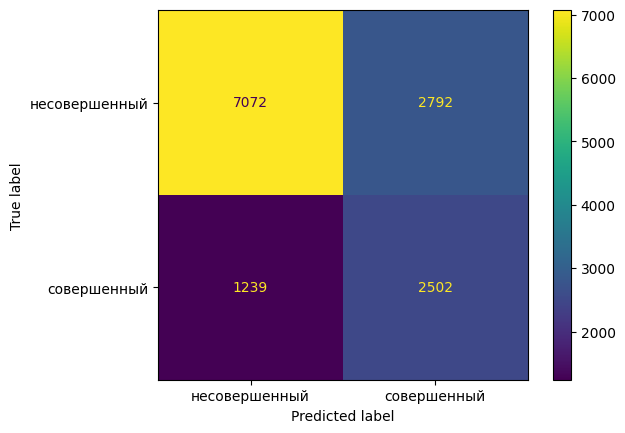

In [164]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, preds_test),
                              display_labels=['несовершенный', 'совершенный'])
disp.plot()

In [152]:
X_test['контекст'].iloc[0]

'В 1982-м году в США эмигрировал и Бобышев.'

In [153]:
def get_texts_with_false_pred(preds=preds_test,
                              labels=y_test,
                              texts=X_test['контекст']):
  false_neg, false_pos, true_pos, true_neg, indef_asp, junk_ind = [], [], [], [], [], []
  for inx, i in enumerate(tuple(zip(preds, labels))):
    pred, label = i
    if texts.iloc[inx]:
      if label != pred:
        if pred == -2:
          indef_asp.append(texts.iloc[inx])
        elif label == 1:
          false_neg.append(texts.iloc[inx])
        elif label == 0:
          false_pos.append(texts.iloc[inx])
      elif label == pred:
        if label == 1:
          true_pos.append(texts.iloc[inx])
        elif label == 0:
          true_neg.append(texts.iloc[inx])
    else:
      junk_ind.append(inx)
  return  {
      'FN': false_neg,
      'FP': false_pos,
      'TP': true_pos,
      'TN': true_neg,
      'INDEF': indef_asp,
      'junk': junk_ind
  }

class_report = get_texts_with_false_pred()

In [154]:
# model: perfective | label: perfective

print(len(class_report['TP']))
for i in sorted(class_report['TP'][:20], key=len):
  print(i, end='\n')

2502
В 1982-м году в США эмигрировал и Бобышев.
Я телефонировал в штаб отряда, там ждут вас.
Рома, ты иди к шефу, он велел, чтобы ты сразу к нему явился, как только придешь.
7 «А как же тогда Моисей велел, “разводясь с женой, давать ей письмо о разводе”»? — говорят они.
Прибалтийского военного округа, что фашисты находятся северо-западнее Каунаса, что им удалось форсировать реку Неман.
Коллектор, протяжением в 3,5 км, изолирует воды сероводородистых источников и отведет их в море на 150 метров от берега.
Наше объявление сегодня появилось в «Каспии», и на сегодняшнем годовом ужине технологов интересовались и обещали абонироваться.
Кузина Мила. За стеклом» инсценировали военный бунт В субботу в realty-шоу «За стеклом», выходящем на канале ТВС, произошло ЧП.
Наш доблестный летчик штабс-ротмистр Ширков атаковал неприятельский аэроплан и заставил его круто снизиться в районе германских позиций.
4-ая Кубанская дивизия атаковала между Саратовским большаком и селом Городище, а Сводно-Горская д

In [155]:
# model: imperfective | label: imperfective

print(len(class_report['TN']))
for i in sorted(class_report['TN'][:20], key=len):
  print(i, end='\n')

7072
Иногда надо просто уметь абстрагироваться, — уверяет Саша.
И я гарантирую, что вы навсегда запомните наш благодатный край.
Госснаб не определил номенклатуру строительных материалов, фонды на которые централизуются.
Уход в туманность, которую нет нужды смыслово идентифицировать и оценивать, поскольку это просто туманность.
Нет, лучше не женись, — сказал Джапаридзе. — Распишешься — сразу свободу потеряешь, зарплату отдавай, пить не смей.
И вовсе нет приевшейся стилизации бессвязности, которая должна симулировать подлинное изображение психического, или мыслительного процесса.
Обмен генов объединял это сообщество в достаточной степени, чтобы его члены не могли эволюционировать как раздельные биологические единицы.
У него учился Иероним, живший на рубеже IV — V веков, цитировал его сочинения, многое просто заимствовал, редактируя в свою христианскую сторону.
Повторяя свой импровизированный стих, дети могут деформировать слово, но ни при каких обстоятельствах не нарушат напева, который 

In [156]:
# model: imperfective | label: perfective

print(len(class_report['FN']))
for i in sorted(class_report['FN'], key=len):
  print(i, end='\n')

1239
деваласвою барышню.
реализовать2015 год.
Я… Женись. Я осекся.
И не жени ты меня на ней!
атаковалЧики рассыпались.
клонировализеркальном логотипе.
активизироватьпартии в обществе.
Брат рано женился и жил не дома.
млад стремится абонироваться. 2)
В тот день его убило, а ее ранило…
его отсутствие второй раз женился.
изолировалаправительственную связь.
Женилсялачуге справляли, в Лосинке.
Когда мы вырастем, я на тебе женюсь.
велелпервозажжённые фонари Петровки.
реализоватьбольших и дерзких полетах.
И на той, другой, готов был жениться.
Все дело в том, что его хотят женить.
А для чего ты хочешь жениться на мне?
А не женился-то, прикинь, сколько лет?
активизироватьстратегические интересы.
Она, конечно, хочет женить его на себе.
Миша, не думают наши тебя женить зимой?
Жениться на мне стало смыслом его жизни.
И, ma chere, что за охота абонироваться?
Оставайся со мной, старина, я тебя женю.
А с сегодняшнего дня велели цены поднять.
Он пять лет назад эмигрировал из Армении.
Мы арендовали лед

In [ ]:
# model: perfective | label: imperfective

print(len(class_report['FP']))
for i in sorted(class_report['FP'][:20], key=len):
  print(i, end='\n')

2812
Ее надо только умело утилизировать и профинансировать.
Женить его нужно, — чуть не хором заговорили консерваторские.
Правая часть Предпарламента вотировала против добровольного «временного» роспуска.
Какова мера факта и мера вымысла в вашей прозе и как трансформировался в ней ваш личный жизненный опыт?
Соня расплылась в улыбке. Твою машину уже эвакуировали. Если понадобится, ты сможешь найти ее на парковке.
Это мера вероятности того, что с помощью теста удастся правильно идентифицировать людей, не имеющих болезни.
Она продавала мебель фирме «Бастион», «Бастион» — еще нескольким фирмам, которые арендовали площади в магазинах «Три кита» и «Гранд».
В нынешнем вагоне тоже только кондукторша, киргизка — суммирует набранную за день мелочь, бормочет: «Ой как много, ой не сосчитать мне»; не отвлекать же, собьется.
По тому же принципу и окончания ледников, покрытые конечной мореной, при потеплении климата должны некоторое время сохраняться после того, как выше ледник уже деградировал полно